<a href="https://colab.research.google.com/github/Ronak-edision/Transformer/blob/main/Image_caption_resnet_transformer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

import torchvision
from torchvision import transforms
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)



# Read Data

In [ ]:
csv_path = '/content/drive/MyDrive/captions.txt'
df = pd.read_csv(csv_path)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


# get the images from the zip

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Images.zip'
extract_path = '/content/flickr8k_images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the extracted files
extracted_files = os.listdir(extract_path)
print(extracted_files[:10])  # Print the first 10 files

['Images']


# test the image and its caption


In [ ]:
import matplotlib.image as mpimg

# Extract the first four data points
data_points = df.iloc[[0, 5, 10, 15]]

# Display the first four images and their corresponding captions
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, ax in enumerate(axes.flatten()):
    img_path = os.path.join(extract_path, 'Images', data_points.iloc[i]['image'])
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(data_points.iloc[i]['caption'])
    ax.axis('off')

plt.tight_layout()
plt.show()

# preprocessing
<h3> Remove Single Character and non alpha Words. Add , and tokens. token is appended such that length in max_seq_len (maximum length across all captions which is 33 in our case)

In [ ]:
def remove_single_char_word(word_list):
    lst=[]
    for word in word_list:
        if len(word)>1:
            lst.append(word)
    return lst

In [ ]:
df['cleaned_caption']= df['caption'].apply(lambda caption: ['<start>']+[word.lower() if word.isalpha() else '' for word in caption.split(" ")]+['<eos>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))


In [ ]:
df.head()

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <eos>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <eos>]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, little, girl, climbing, into, wooden, playhouse, <eos>]"
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .,"[<start>, little, girl, climbing, the, stairs, to, her, playhouse, <eos>]"
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .,"[<start>, little, girl, in, pink, dress, going, into, wooden, cabin, <eos>]"


In [ ]:

max_count=df['caption'].apply(lambda caption: len(caption.split())).max()
max_count

38

In [ ]:
max_seq_len=df['cleaned_caption'].apply(lambda cleaned_caption: len(cleaned_caption)).max()
max_seq_len

33

In [ ]:
df['cleaned_caption']= df['cleaned_caption'].apply(lambda caption :caption+['<pad>']*(max_seq_len-len(caption)))

In [ ]:
df.head(3)

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <eos>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <eos>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, little, girl, climbing, into, wooden, playhouse, <eos>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


In [ ]:
# df['seq_len_count'] = df['cleaned_caption'].str.len()
# df.head(10)

# create vocab mapping of token to ID

In [ ]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
vocab_list = sorted(word_dict, key = word_dict.get, reverse=True)

In [ ]:
print(len(vocab_list))
print(vocab_list[:5])

8360
['<pad>', '<start>', '<eos>', 'in', 'the']


In [ ]:
vocab_size= len(vocab_list)
vocab_size


8360

In [ ]:
index_to_vocab= {index: vocab for index, vocab in enumerate(vocab_list)}
vocab_to_index= {vocab: index for index, vocab in enumerate(vocab_list)}
print(len(index_to_vocab), len(vocab_to_index))

8360 8360


# convert seq of tokens to IDs

In [ ]:
df['text_seq']= df['cleaned_caption'].apply(lambda caption : [vocab_to_index[vocab] for vocab in caption])

In [ ]:
df.head()

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <eos>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <eos>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, little, girl, climbing, into, wooden, playhouse, <eos>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 39, 18, 118, 63, 192, 2402, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .,"[<start>, little, girl, climbing, the, stairs, to, her, playhouse, <eos>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 39, 18, 118, 4, 389, 19, 59, 2402, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .,"[<start>, little, girl, in, pink, dress, going, into, wooden, cabin, <eos>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 39, 18, 3, 89, 168, 311, 63, 192, 2949, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# split in train and validation data

In [ ]:
df= df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
val = df.iloc[int(0.9*len(df)):]

In [ ]:
print(len(train), train['image'].nunique(),train['image'].nunique()*5 )
print(len(val), val['image'].nunique(),val['image'].nunique()*5 )

36409 7282 36410
4046 810 4050


# extract features from images using resnet

In [ ]:
unq_train_imgs= train[['image']].drop_duplicates()
unq_val_imgs= val[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_val_imgs))

7282 810


In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class extractImageFeaturesResnetDataset():
    def __init__(self, data):
        self.data = data
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx]['image']
        img_loc = '/content/flickr8k_images/Images/'+str(image_name)

        img= Image.open(img_loc)
        t_img= self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [ ]:
train_ImageDataset_Resnet= extractImageFeaturesResnetDataset(unq_train_imgs)
train_ImageDataLoader_Resnet= DataLoader(train_ImageDataset_Resnet, batch_size= 1, shuffle=False)

In [ ]:
val_ImageDataset_Resnet= extractImageFeaturesResnetDataset(unq_val_imgs)
val_ImageDataLoader_Resnet= DataLoader(val_ImageDataset_Resnet, batch_size= 1, shuffle=False)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
resnet18

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 23.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:


list(resnet18._modules)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [ ]:
resnet18Layer4= resnet18._modules.get('layer4').to(device)
resnet18Layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

# extract the embedding of image from the layer 4 of pre trained resnet

Understanding Hook Parameters (m, i, o):

m → Model layer where the hook is applied (layer4 in this case).
i → Input to that layer (not used here).
o → Output of the layer (512×7×7 feature map).

1 → Single image batch.
512 → Number of channels in layer4 output.
7 × 7 → Spatial feature map size (ResNet downscales 224×224 input to 7×7 at layer4

A hook is a function that runs automatically during forward propagation.
register_forward_hook(copy_data) tells PyTorch to call copy_data() whenever layer4 processes an image.
Running the Image Through ResNet


resnet18(t_img)
This passes t_img through ResNet.
The hook captures the layer4 output and stores it in my_embedding.
Removing the Hook


h.remove()
Hooks persist until removed, so we remove it after one forward pass.
Otherwise, multiple hooks would be active, causing errors.

In [ ]:
def get_vector(t_img):
    t_img = Variable(t_img)
    my_embedding = torch.zeros(1,512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = resnet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)

    h.remove()
    return my_embedding

In [ ]:
extract_imgFtr_ResNet_train= {}

for image_name, t_img in tqdm(train_ImageDataLoader_Resnet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_train[image_name[0]]= embdg

In [ ]:
import os

folder_path = "/content/drive/My Drive/resnet_embedding"
os.makedirs(folder_path, exist_ok=True)

save_path = os.path.join(folder_path, "EncodedImageTrainResNet.pkl")

with open(save_path, "wb") as f:
    pickle.dump(extract_imgFtr_ResNet_train, f)

print("Features saved to Google Drive:", save_path)

In [ ]:
extract_imgFtr_ResNet_val= {}

for image_name, t_img in tqdm(val_ImageDataLoader_Resnet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_val[image_name[0]]= embdg

In [ ]:
folder_path = "/content/drive/My Drive/resnet_embedding"
os.makedirs(folder_path, exist_ok=True)

save_path = os.path.join(folder_path, "EncodedImageValResNet.pkl")

with open(save_path, "wb") as f:
    pickle.dump(extract_imgFtr_ResNet_val, f)

print("Features saved to Google Drive:", save_path)

#Load the embedding from the google drive

In [ ]:
with open("/content/drive/My Drive/resnet_embedding/EncodedImageTrainResNet.pkl", "rb") as f:
    extract_imgFtr_ResNet_train = pickle.load(f)

with open("/content/drive/My Drive/resnet_embedding/EncodedImageValResNet.pkl", "rb") as f:
    extract_imgFtr_ResNet_val = pickle.load(f)



In [ ]:
extract_imgFtr_ResNet_train['1000268201_693b08cb0e.jpg'].shape
#(batch_size, channels, height, width)

torch.Size([1, 512, 7, 7])

In [ ]:
len(extract_imgFtr_ResNet_train)

7282

In [ ]:
extract_imgFtr_ResNet_val['436015762_8d0bae90c3.jpg'].shape

torch.Size([1, 512, 7, 7])

In [ ]:
len(extract_imgFtr_ResNet_val)

810

# Create DataLoader which will be used to load data into Transformer Model.


<h3> FlickerDataSetResnet will return caption sequence, 1 timestep left shifted caption sequence which model will predict and Stored Image features from ResNet.

In [ ]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_dict):
        self.data = data
        self.encodedImgs = pkl_dict

        # Check if all image names in the dataset are in the precomputed embeddings dictionary
        missing_images = []
        for image_name in self.data['image']:
            if image_name not in self.encodedImgs:
                missing_images.append(image_name)

        if missing_images:
            print(f"Missing images from dictionary: {len(missing_images)} images not found!")
            print(missing_images)  # Print the names of the missing images
        else:
            print("All images found in the encoded image dictionary.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        caption_seq = self.data.iloc[idx]['text_seq']  # Get the caption as a sequence of word indices
        target_seq = caption_seq[1:] + [0]  # Left-shifted target sequence for training (this is for teacher forcing)

        image_name = self.data.iloc[idx]['image']  # Corrected: Use idx to index the row correctly

        # Check if image exists in the dictionary
        if image_name not in self.encodedImgs:
            raise KeyError(f"Image '{image_name}' not found in precomputed ResNet features.")

        image_tensor = self.encodedImgs[image_name]  # Retrieve precomputed ResNet feature

        # Reshape feature map from (1, 512, 7, 7) → (1, 7, 7, 512) for better compatibility
        image_tensor = image_tensor.permute(0, 2, 3, 1)

        # Flatten spatial dimensions (7x7 → 49) while keeping 512 channels
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))  # (batch_size, num_patches=49, 512)

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view


In [ ]:
train_dataset_resnet = FlickerDataSetResnet(train, extract_imgFtr_ResNet_train)
train_dataloader_resnet= DataLoader(train_dataset_resnet, batch_size = 64, shuffle=True)

All images found in the encoded image dictionary.


In [ ]:
train_dataset_resnet[3]

(tensor([   1,   39,   18,  118,    4,  389,   19,   59, 2402,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([  39,   18,  118,    4,  389,   19,   59, 2402,    2,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([[[0.0000, 1.3488, 0.7238,  ..., 1.6806, 0.0000, 0.2740],
          [0.0000, 1.1809, 1.1561,  ..., 1.7943, 0.0000, 0.2323],
          [0.0000, 1.4267, 2.6801,  ..., 0.8992, 0.0000, 0.1237],
          ...,
          [1.0814, 1.6378, 0.7406,  ..., 0.9230, 2.1125, 0.0000],
          [0.6624, 2.9292, 0.4284,  ..., 0.7886, 0.0000, 0.0000],
          [0.3689, 3.2503, 0.3899,  ..., 0.6421, 0.2543, 0.0000]]]))

In [ ]:
# Checking a batch from the dataloader
for caption_seq, target_seq, image_embed in train_dataloader_resnet:
    print(caption_seq.shape, target_seq.shape, image_embed.shape)
    break  # Print the shape of the first batch

torch.Size([64, 33]) torch.Size([64, 33]) torch.Size([64, 1, 49, 512])


In [ ]:
for caption_seq, target_seq, image_embed in train_dataloader_resnet:
    print(caption_seq.shape, target_seq.shape, image_embed.shape)
    break


torch.Size([64, 33]) torch.Size([64, 33]) torch.Size([64, 1, 49, 512])


In [ ]:
val_dataset_resnet = FlickerDataSetResnet(val, extract_imgFtr_ResNet_val)
val_dataloader_resnet= DataLoader(val_dataset_resnet, batch_size = 64, shuffle=False)

All images found in the encoded image dictionary.


# Create transformer decoder Model

<h3>
 This Model will take caption sequence and the extracted resnet image features as input and ouput 1 timestep shifted (left) caption sequence.

<h3> In the Transformer decoder, lookAhead and padding mask has also been applied

# Positional encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #1, 33
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # 1, 512

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)  # not trainable

    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        # Add positional encoding to the input
        x = x + self.pe[:, :x.size(1), :]  # Ensure pe is broadcasted correctly
        return self.dropout(x)

# transformer decoder

In [ ]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Add this line

        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)

        #  Define TransformerDecoderLayer first
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embedding_size,
            nhead=n_head
        )

        #  Pass decoder_layer into TransformerDecoder
        self.TransformerDecoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layer
        )

        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)  # Word embeddings
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)  # Final projection

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)  #  Fixed typo

    def generate_mask(self, size, decoder_inp):
        """Creates masks for the transformer decoder."""
        device = decoder_inp.device

        #  Generate upper-triangular mask (for autoregressive decoding)
        decoder_input_mask = torch.triu(torch.ones(size, size, device=device) == 1).transpose(0,1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        #  Pad mask for ignoring padding tokens
        decoder_input_pad_mask = decoder_inp == 0  # True for PAD tokens, False otherwise

        return decoder_input_mask, decoder_input_pad_mask# (33, 33),(64, 33)

    def forward(self, encoded_image, decoder_inp):
        """Forward pass for image captioning model."""
        device = next(self.parameters()).device

        # Ensure inputs are on the same device
        encoded_image = encoded_image.to(device)
        decoder_inp = decoder_inp.to(device)
        # print('before encoder', encoded_image.shape)# ([64, 49, 512])

        # Fix input permutation for image embeddings
        encoded_image = encoded_image.permute(1, 0, 2)  # (batch, feature_map/patches=7*7, features) → (patches, batch, features)
        # print('after encoder ', encoded_image.shape)#[49, 64, 512])

        # Correct embedding scaling
        decoder_inp_embed = self.embedding(decoder_inp) * math.sqrt(self.embedding_size)
        # print('before decoder and positional encoding ',decoder_inp_embed.shape)#([64, 33, 512]

        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        # print('before decoder after positional encoding ',decoder_inp_embed.shape)#([64, 33, 512])

        # Permute for Transformer input
        decoder_inp_embed = decoder_inp_embed.permute(1, 0, 2)
        # print('after decoder ',decoder_inp_embed.shape)#([33, 64, 512])

        # Generate masks
        decoder_input_mask, decoder_input_pad_mask = self.generate_mask(decoder_inp.size(1), decoder_inp.to(device))

        # Transformer Decoder
        decoder_output = self.TransformerDecoder(
            tgt=decoder_inp_embed, #33, 64, 512
            memory=encoded_image,  # Image embeddings act as memory(49, 64, 512)
            tgt_mask=decoder_input_mask.to(device),
            tgt_key_padding_mask=decoder_input_pad_mask.to(device)
        )

        # Final output projection to vocab size
        final_output = self.last_linear_layer(decoder_output)

        return final_output, decoder_input_pad_mask


In [ ]:
# Get the first batch from the DataLoader
X = next(iter(train_dataloader_resnet))

# Check if X is a list or tuple
if isinstance(X, (list, tuple)):
    # Unpack the batch
    caption_seq, target_seq, image_embed = X

    # Print the shapes of each component
    print(f"caption_seq shape: {caption_seq.shape}")
    print(f"target_seq shape: {target_seq.shape}")
    print(f"image_embed shape: {image_embed.shape}")
else:
    # If X is a single tensor, print its shape
    print(f"X shape: {X.shape}")

caption_seq shape: torch.Size([64, 33])
target_seq shape: torch.Size([64, 33])
image_embed shape: torch.Size([64, 1, 49, 512])


In [ ]:

decoder_input_mask = torch.triu(torch.ones(33, 33))
decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

decoder_input_pad_mask = caption_seq == 0  # True for PAD tokens, False otherwise
decoder_input_pad_mask[63]


tensor([False, False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True])

In [ ]:
# ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
# ictModel.forward(image_embed.squeeze(1),caption_seq)


# train the model

<p>The cross entropy loss has been masked at time steps where input token is <'pad'>.

In [ ]:
EPOCH = 15

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(ignore_index = 0, reduction='none')
min_val_loss = float('Inf')


In [ ]:
import os

# Define the folder path in Google Drive
folder_path = "/content/drive/My Drive/image_caption"
os.makedirs(folder_path, exist_ok=True)

# Define the model save path
save_path = os.path.join(folder_path, "BestModel.pth")

# Training loop
min_val_loss = float("inf")

train_losses = []
val_losses = []
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()


    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)#(64, 49,512)
        caption_seq = caption_seq.to(device)  # Shape: (64, 33)
        target_seq = target_seq.to(device) # Shape: (64, 33)

        #forward pass
        output, padding_mask = ictModel.forward(image_embed, caption_seq)# output shape: (33, 64, vocab_size)
        output = output.permute(1, 2, 0) # Reshape to (64, vocab_size, 33)

        #compute loss
        loss = criterion(output, target_seq)# Shape: (64, 33)
        # padding_mask = padding_mask.to(device)
        # loss_masked = torch.mul(loss, padding_mask) #Apply mask to ignore padding tokens

        final_batch_loss = torch.sum(loss) / torch.sum(padding_mask)

        final_batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(ictModel.parameters(), max_norm=1.0)
        optimizer.step()

        total_epoch_train_loss += torch.sum(loss).detach().item()
        total_train_words += torch.sum(padding_mask).item()

    total_epoch_train_loss = total_epoch_train_loss / total_train_words if total_train_words > 0 else 0
    train_losses.append(total_epoch_train_loss)


    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in val_dataloader_resnet:
            image_embed = image_embed.squeeze(1).to(device) # Shape: (64, 49, 512)
            caption_seq = caption_seq.to(device) # Shape: (64, 33)
            target_seq = target_seq.to(device) # Shape: (64, 33)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0) # Reshape to (64, vocab_size, 33)

            loss = criterion(output, target_seq)
            # padding_mask = padding_mask.to(device)
            # loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss).detach().item()
            total_valid_words += torch.sum(padding_mask).item()

    total_epoch_valid_loss = total_epoch_valid_loss / total_valid_words if total_valid_words > 0 else 0

    val_losses.append(total_epoch_valid_loss)


    print(f"Epoch {epoch} -> Training Loss: {total_epoch_train_loss:.4f}, Eval Loss: {total_epoch_valid_loss:.4f}")

    if min_val_loss > total_epoch_valid_loss:
        print(f"Saving model at epoch {epoch}...")
        torch.save(ictModel.state_dict(), save_path)  # Save only model weights
        min_val_loss = total_epoch_valid_loss

    scheduler.step(total_epoch_valid_loss)

print(f"Model saved at: {save_path}")


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 0 -> Training Loss: 2.8911, Eval Loss: 2.4241
Saving model at epoch 0...
Epoch 1 -> Training Loss: 2.2795, Eval Loss: 2.1712
Saving model at epoch 1...
Epoch 2 -> Training Loss: 2.1015, Eval Loss: 2.0633
Saving model at epoch 2...
Epoch 3 -> Training Loss: 1.9989, Eval Loss: 1.9888
Saving model at epoch 3...
Epoch 4 -> Training Loss: 1.9259, Eval Loss: 1.9366
Saving model at epoch 4...
Epoch 5 -> Training Loss: 1.8679, Eval Loss: 1.8975
Saving model at epoch 5...
Epoch 6 -> Training Loss: 1.8209, Eval Loss: 1.8671
Saving model at epoch 6...
Epoch 7 -> Training Loss: 1.7792, Eval Loss: 1.8374
Saving model at epoch 7...
Epoch 8 -> Training Loss: 1.7418, Eval Loss: 1.8160
Saving model at epoch 8...
Epoch 9 -> Training Loss: 1.7093, Eval Loss: 1.7970
Saving model at epoch 9...
Epoch 10 -> Training Loss: 1.6793, Eval Loss: 1.7786
Saving model at epoch 10...
Epoch 11 -> Training Loss: 1.6517, Eval Loss: 1.7634
Saving model at epoch 11...
Epoch 12 -> Training Loss: 1.6256, Eval Loss: 1.

#load model

In [ ]:
ictModel = ImageCaptionModel(n_head=16, n_decoder_layer=4, vocab_size=vocab_size, embedding_size=512).to(device)
ictModel.load_state_dict(torch.load("/content/drive/My Drive/image_caption/BestModel.pth"))


<h2> load in cpu

In [ ]:
device = torch.device("cpu")
ictModel = ImageCaptionModel(n_head=16, n_decoder_layer=4, vocab_size=vocab_size, embedding_size=512).to(device)

# Load the model state dict with map_location to CPU
ictModel.load_state_dict(torch.load("/content/drive/My Drive/image_caption/BestModel.pth", map_location=device))

# Now you can use the model for inference on CPU
ictModel.eval()

ImageCaptionModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2)

# loss plot

In [ ]:
import matplotlib.pyplot as plt

# Ensure all losses are moved to the CPU and converted to standard Python lists
train_losses = [loss.item() if torch.is_tensor(loss) else loss for loss in train_losses]
val_losses = [loss.item() if torch.is_tensor(loss) else loss for loss in val_losses]

plt.figure(figsize=(8, 6))
plt.plot(range(EPOCH), train_losses, label="Train Loss")
plt.plot(range(EPOCH), val_losses, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()


# inferencing

In [ ]:
word_to_index = vocab_to_index
index_to_word = index_to_vocab

# Define tokens
start_token = word_to_index['<start>']
end_token = word_to_index['<eos>']
pad_token = word_to_index['<pad>']
max_seq_len = 33

# Load image embeddings
valid_img_embed = pd.read_pickle('/content/drive/My Drive/resnet_embedding/EncodedImageValResNet.pkl')

extract_path= "/content/flickr8k_images/Images/"




In [ ]:
def generate_caption(K, img_nm):
    # Load and display the image
    img_loc = os.path.join(extract_path, img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

    # Set the model to evaluation mode
    ictModel.eval()

    # Print the actual captions for the image
    valid_img_df = val[val['image'] == img_nm]
    print("Actual Caption:")
    print(valid_img_df['caption'].tolist())

    # Get the image embedding
    img_embed = valid_img_embed[img_nm].to(device)

    # Reshape the image embedding
    img_embed = img_embed.permute(0, 2, 3, 1)  # Change shape to (batch_size, H, W, C)
    img_embed = img_embed.reshape(img_embed.size(0), -1, img_embed.size(3))  # Flatten spatial dimensions

    # Initialize the input sequence
    input_seq = [pad_token] * max_seq_len
    input_seq[0] = start_token
    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)  # Add batch dimension

    # Store the predicted caption
    predicted_sentence = []

    # Generate the caption
    with torch.no_grad():
        for eval_iter in range(max_seq_len - 1):  # Iterate up to max_seq_len - 1
            # Forward pass through the model
            output, padding_mask = ictModel.forward(img_embed, input_seq)

            # Get the output for the current step
            output = output[eval_iter, 0, :]

            # Exclude padding tokens from sampling
            output[pad_token] = -float('inf')  # Set logit for padding token to -inf

            # Sample the next word
            values, indices = torch.topk(output, K)
            next_word_index = random.choices(indices.tolist(), values.tolist(), k=1)[0]
            next_word = index_to_word[next_word_index]

            # Update the input sequence with the predicted word
            input_seq[:, eval_iter + 1] = next_word_index

            # Stop if <end> token is generated
            if next_word == '<eos>':
                break

            # Append the predicted word to the sentence
            predicted_sentence.append(next_word)

    # Print the predicted caption
    print("\nPredicted Caption:")
    print(" ".join(predicted_sentence + ['.']))

# Example inference

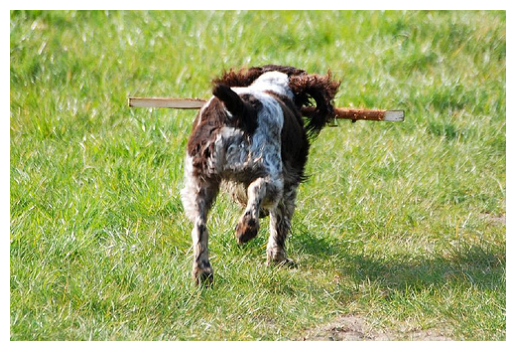

Actual Caption:
['the brown and white dog is carrying a stick in his mouth .', 'The brown dog is running away with a stick in its mouth .', 'Dog fetching huge stick .', 'A brown and white dog runs away carrying a big stick .', 'A dog running through the grass with a stick in his mouth .']


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



Predicted Caption:
black and white dog is running through the grass .


In [ ]:
generate_caption(1, unq_val_imgs.iloc[109]['image'])

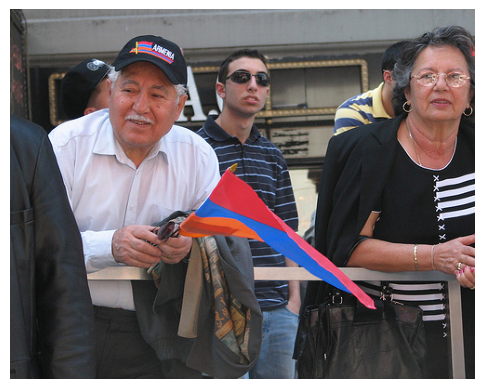

Actual Caption:
['An elder man in a white shirt and cap waves a flag as a group of people stand behind him .', 'A man holding flag and a woman behind a railing .', 'An older man with a red , blue , and orange flag in a crowd', 'A man and a woman standing with a group of spectators .', 'A man holding a flag stands next to a woman wearing black and white .']

Predicted Caption:
man in black jacket and white shirt is holding up sign .


In [ ]:
generate_caption(1, unq_val_imgs.iloc[120]['image'])

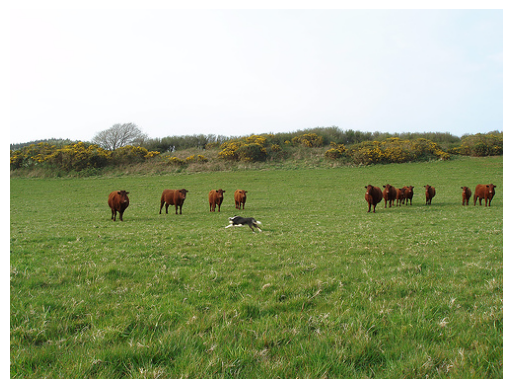

Actual Caption:
['A black and white dog is running through a cow field .', 'A black and white dog running in the grass where there are some cows .', 'A calf is running in the fields while cows look on .', 'A cow herd grazing in the pasture with a dog running in the foreground .', 'A dog running in the grass around sheep .']

Predicted Caption:
two dogs are running through field .


In [ ]:
generate_caption(1, unq_val_imgs.iloc[106]['image'])

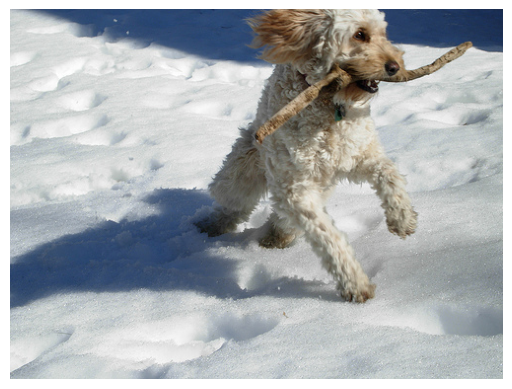

Actual Caption:
['A white dog with light brown markings has a stick in his mouth and his paws in the snow .', 'A white dog holds a stick in its mouth while it runs through snow .', 'a white dog jumps in the snow .', 'A white dog catches a stick in the snow .', 'A tan curly haired dog jumps in the snow with a stick in its mouth .']

Predicted Caption:
dog running in the snow .


In [ ]:
generate_caption(1, unq_val_imgs.iloc[25]['image'])

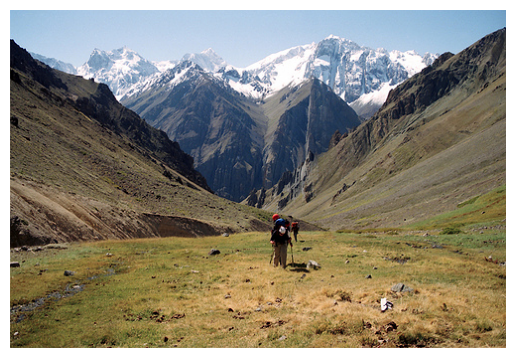

Actual Caption:
['A person hiking at the foot of snowcapped mountains .', 'A person walks in the valley between tall mountains .', 'A person with a backpack and walking stick , walking towards the mountains in the valley below .', 'People with backpacks hiking in the mountains .', 'Three people walk through a valley towards snowy mountains .']

Predicted Caption:
two people are walking through the mountains .


In [ ]:
generate_caption(1, unq_val_imgs.iloc[26]['image'])

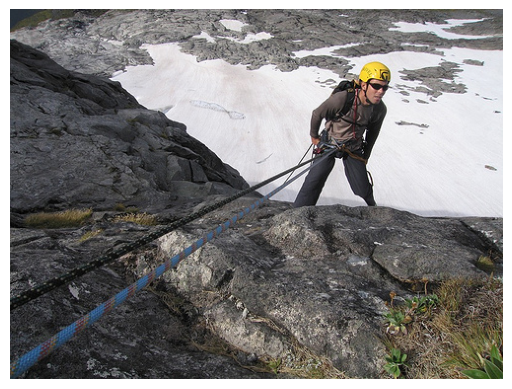

Actual Caption:
['A man in a yellow helmet climbs a cliff face , snow behind him .', 'A man is climbing up a wall with a rope', 'A man leans back while climbing a mountain tethered to a rope .', 'He is rock climbing .', 'Man with helmet rock climbing in a snowy area .']

Predicted Caption:
man is standing on rocky cliff .


In [ ]:
generate_caption(1, unq_val_imgs.iloc[30]['image'])

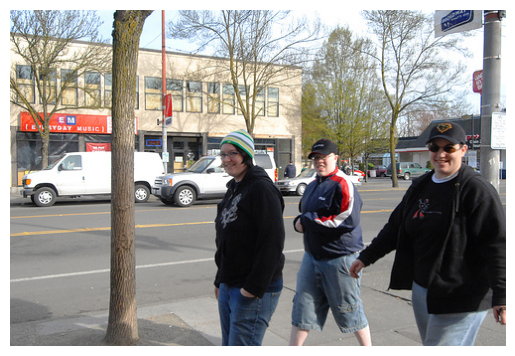

Actual Caption:
['Three men walking on a sidewalk in a city .', 'Three people are walking down the street with cars and buildings in the background .', 'Three people stand along a main road .', 'Three people walking on a sidewalk with 3 light colored cars in the background .', 'three people wearing winter clothes standing on the sidewalk near a street']

Predicted Caption:
group of people in the street .


In [ ]:
generate_caption(1, unq_val_imgs.iloc[35]['image'])

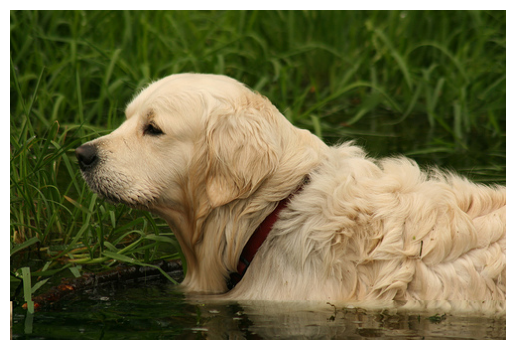

Actual Caption:
['A blonde puppy wearing a red collar is standing in the water .', 'A furry dog with a collar is sitting in a pond .', 'A tan dog swims around in the water .', 'A white dog with long hair wades through a pond surrounded by green grass .', 'White dog at the edge of the water .']

Predicted Caption:
white dog is running through the water .


In [ ]:
generate_caption(1, unq_val_imgs.iloc[238]['image'])